# MATH 420
## Jack Mirenzi - Camilo Velez
## Team HW 3

In [3]:
using LinearAlgebra

using Pkg
Pkg.activate("./p2")
Pkg.instantiate()

using Plots
using DelimitedFiles
using LaTeXStrings
using Polynomials
using EasyFit

files = readdir("Project_2/kn57Nodes1to57_coord/")
files = joinpath.("Project_2/kn57Nodes1to57_coord/", files)

target = files[1]
sources = files[2:end]


"""
Process file and return matrix
"""
function process_file(fn::String)
    m = readdlm(fn, Float64, header=false)
    return m
end

target = process_file(target)
sources = process_file.(sources)

function compute_center(m::Matrix{Float64})::Vector{Float64}
    n = size(m)[2]
    r = 1 / n * m * ones(n)
    return r
end

function recenter(m::Matrix{Float64})::Matrix{Float64}
    n = size(m)[2]
    m̄ = compute_center(m)
    r = m - m̄ * ones(n)'
    return r
end
function recenter(m::Matrix{Float64}, bar::Vector{Float64})::Matrix{Float64}
    n = size(m)[2]
    m̄ = bar
    r = m - m̄ * ones(n)'
    return r
end

function compute_r(x::Matrix{Float64}, y::Matrix{Float64}; center::Bool=true)::Matrix{Float64}
    if center
        r = recenter(x) * recenter(y)'
    else
        r = x * y'
    end
    return r
end

function compute_svd(x::Matrix{Float64})::NTuple{3,Matrix{Float64}}
    s = svd(x)
    r = (s.U, diagm(s.S), s.Vt)
    return r
end

"""

    Usage:
    Q, a, z = compute_qaz(sources[i], target)
"""
function compute_qaz(x::Matrix{Float64}, y::Matrix{Float64})::Tuple{Matrix{Float64},Float64,Vector{Float64}}
    x̄ = compute_center(x)
    ȳ = compute_center(y)
    X̃ = recenter(x, x̄)
    Ỹ = recenter(y, ȳ)
    u, s, vt = compute_svd(compute_r(X̃, Ỹ, center=false))
    Q = vt' * u'
    a = tr(s) / (norm(recenter(X̃)))^2
    z = x̄ - 1 / a * Q' * ȳ
    return (Q, a, z)
end


function compute_alignment_error(x::T, y::T, Q::T, a::Float64, z::Vector{Float64})::Float64 where {T<:Matrix{Float64}}
    m = a * Q * (x - z * ones(size(x)[2])') - y
    return norm(m)
end
function compute_alignment_error(x::Matrix{Float64}, y::Matrix{Float64})::Float64
    Q, a, z = compute_qaz(x, y)
    return compute_alignment_error(x, y, Q, a, z)
end

zt(t::Float64, z::Vector{Float64})::Vector{Float64} = t * z
at(t::Float64, a::Float64)::Float64 = 1 - t + t * a
function matrix_j(Q::Matrix{Float64}, i::Int=1)::Union{Matrix{Float64},UniformScaling{Bool}}
    d = round(det(Q))
    d == 1 && return I
    if d == -1
        v = ones(size(Q)[1])
        v[i] = -1
        return diagm(v)
    else
        error("Bad determinant")
    end
end

function qt(t::Float64, Q::Matrix{Float64}, i::Int=1)::Matrix{Float64}
    J = matrix_j(Q, i)
    return J' * exp(t * log(J * Q))
end

xt(t::Float64, X::Matrix{Float64}, Q::Matrix{Float64}, a::Float64, z::Vector{Float64}; i::Int=1) = at(t, a) * qt(t, Q, i) * (X - zt(t, z) * ones(3)')
xt(t::Float64, X::Matrix{Float64}, tp::Tuple; i::Int=1) = xt(t, X, tp[1], tp[2], tp[3]; i=i)
xt(t::Float64, X::Matrix{Float64}; i::Int=1) = xt(t, X, compute_qaz(X, target); i=i)

function make_gif(x::Matrix{Float64}, s::Int)
    x_min::Matrix{Real} = ones(100, 3)
    x_max::Matrix{Real} = ones(100, 3)

    for i in 1:100
        x_ = xt(i / 100, x, compute_qaz(x, y))
        for k in 1:3
            x_min[i, k] = minimum(x_[:, k])
            x_max[i, k] = maximum(x_[:, k])
        end
    end
    up_bounds = maximum.(eachcol(x_max))
    low_bounds = minimum.(eachcol(x_min))

    @gif for i in 1:100
        x_ = xt(i / 100, x, compute_qaz(x, y))
        # Plots.scatter(x_[:, 1], x_[:, 2], x_[:, 3], xlims=(extrema(x_[:, 1])), ylims=(extrema(x_[:, 2])), zlims=(extrema(x_[:, 3])), markercolor=:blue)
        Plots.scatter(x_[:, 1], x_[:, 2], x_[:, 3], xlims=(low_bounds[1], up_bounds[1]), ylims=(low_bounds[2], up_bounds[2]), zlims=(low_bounds[3], up_bounds[3]), markercolor=:blue)
        Plots.scatter!(y[:, 1], y[:, 2], y[:, 3], markercolor=:red)
        if s == 0
            title!(L"X(t), t = %$(i/100)" * "\n" * "No Noisy Source")
        else
            title!(L"X(t), t = %$(i/100)" * "\n" * "Noisy Source Level $(s)")
        end
    end fps = 10
end


  Activating project at `~/MATH420/p2`


make_gif (generic function with 1 method)

Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_knwZ2NE1Kb.gif")
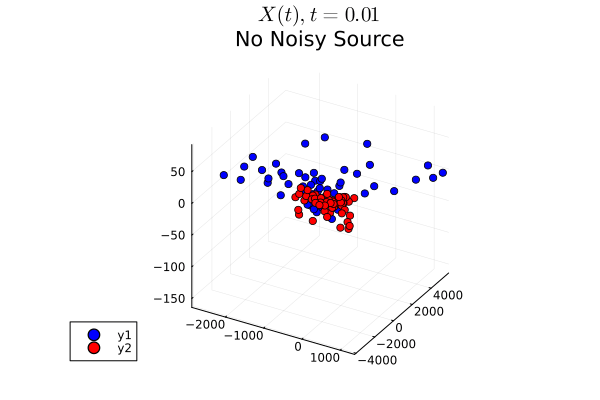

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_knwZ2NE1Kb.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_EJYtElkpwd.gif")
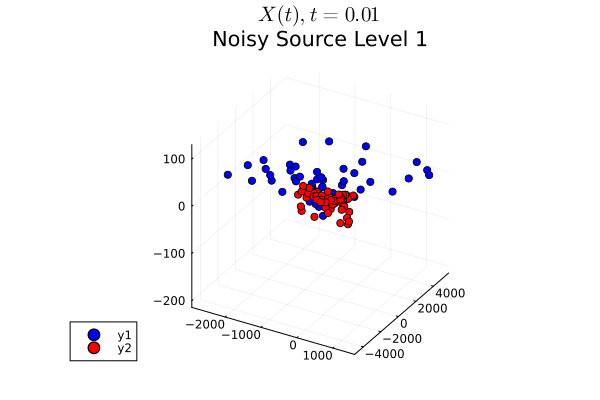

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_EJYtElkpwd.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_Cpiv8J8ps7.gif")
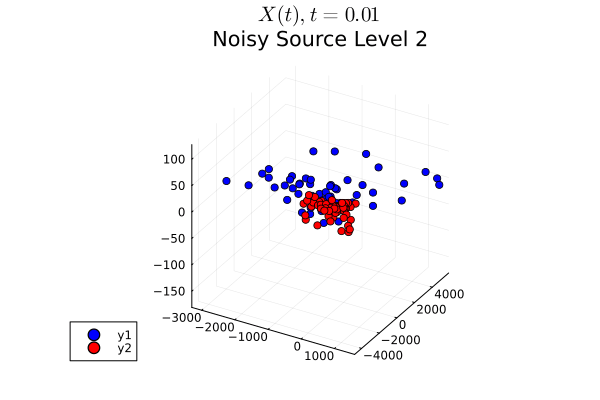

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_Cpiv8J8ps7.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_8jQtstEHWp.gif")
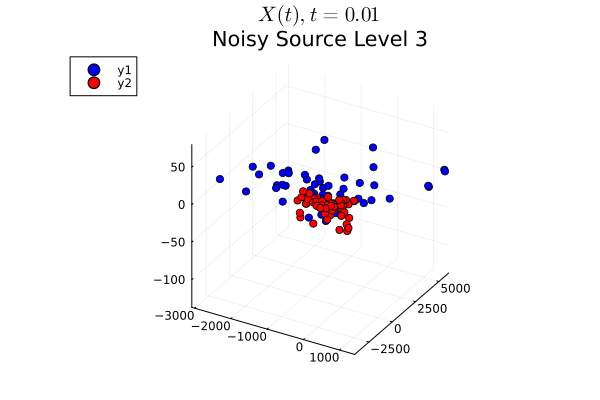

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_8jQtstEHWp.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_klKVoPixIV.gif")
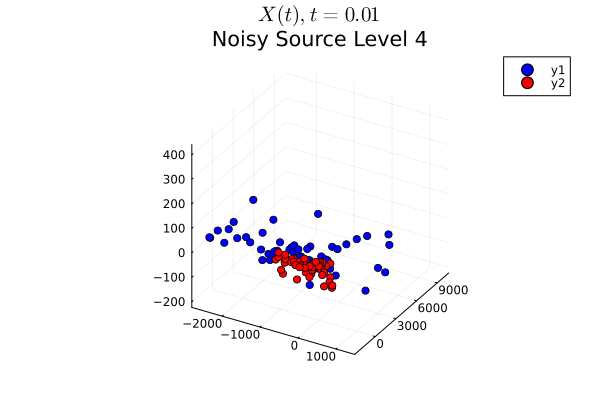

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_klKVoPixIV.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_kVMFMbE5Id.gif")
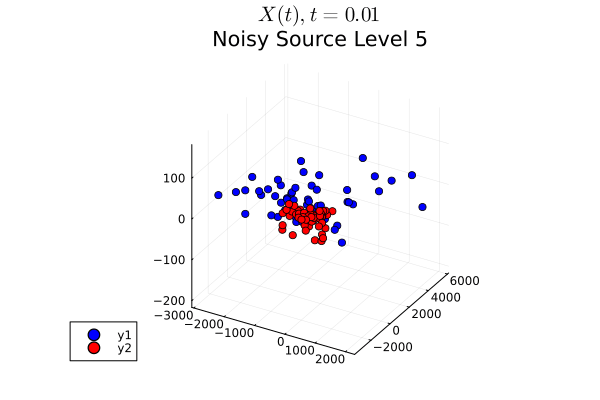

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_kVMFMbE5Id.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_qLYhs7EV8V.gif")
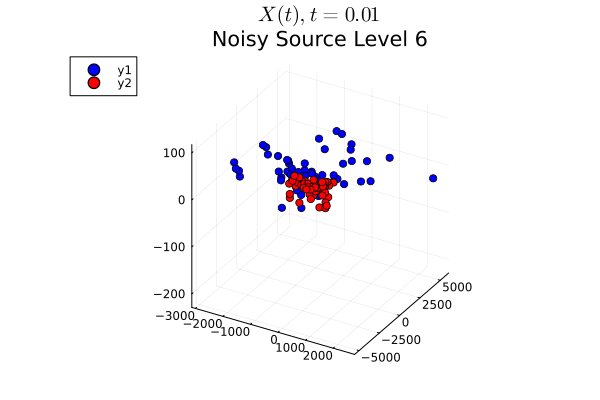

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_qLYhs7EV8V.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_uB4FEVyBCx.gif")
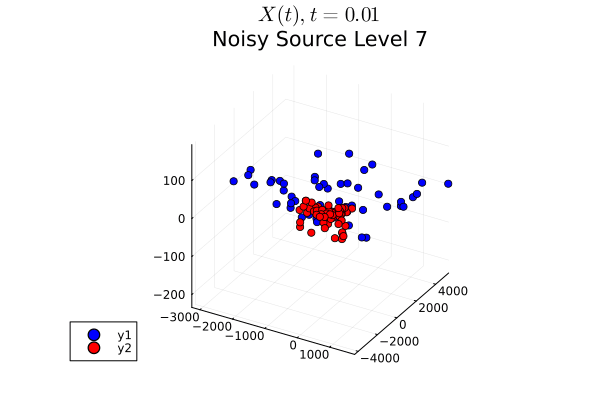

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_uB4FEVyBCx.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_0vKfSbOR4x.gif")
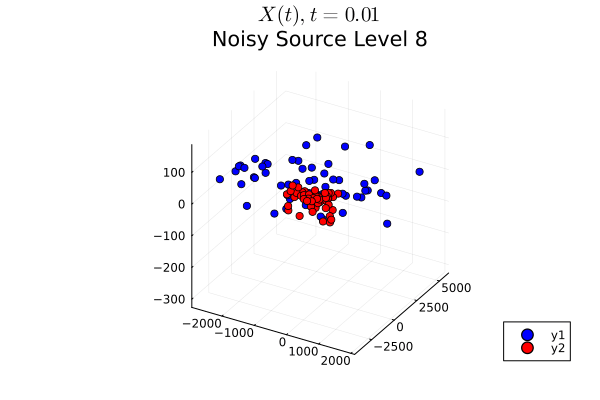

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_0vKfSbOR4x.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_aFOfqripgT.gif")
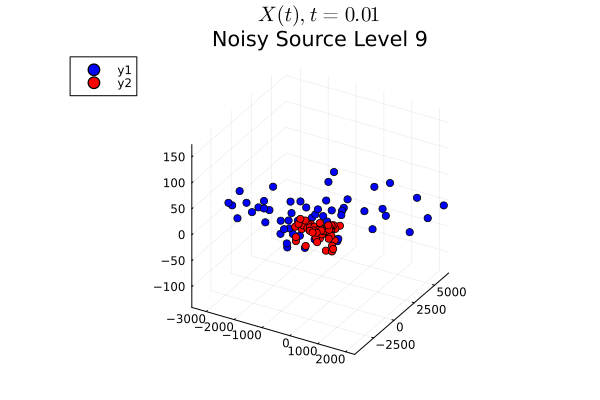

┌ Info: Saved animation to /var/folders/fq/3xjy8gl17c7d1_j25xvpltz80000gn/T/jl_aFOfqripgT.gif
└ @ Plots /Users/camilovelezr/.julia/packages/Plots/io9zQ/src/animation.jl:156


In [4]:
y = target
for (i, x) in enumerate(sources)
    (Q, a, z) = compute_qaz(x, y)
    display(make_gif(x, i - 1))
end

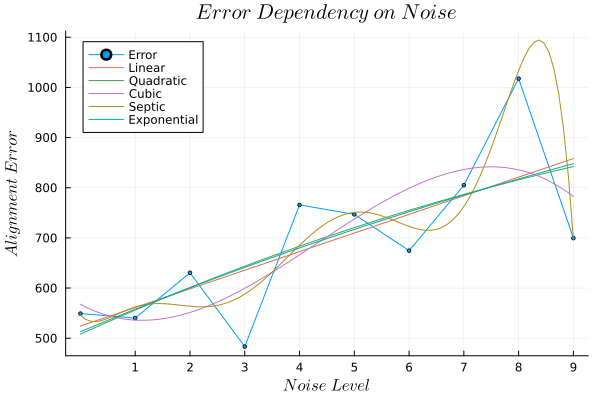

In [5]:
error_plot = [compute_alignment_error(x, y) for x in sources]
j_list = collect(0:9)
Plots.plot(j_list, error_plot, markers=2, xticks=1:10, labels="Error")
Plots.plot!(Polynomials.fit(j_list, error_plot, 1), extrema(j_list)..., labels="Linear")
Plots.plot!(Polynomials.fit(j_list, error_plot, 2), extrema(j_list)..., labels="Quadratic")
Plots.plot!(Polynomials.fit(j_list, error_plot, 3), extrema(j_list)..., labels="Cubic")
Plots.plot!(Polynomials.fit(j_list, error_plot, 7), extrema(j_list)..., labels="Septic")

exp_fit = fitexp(j_list, error_plot)
Plots.plot!(exp_fit.x, exp_fit.y, labels="Exponential")
title!(L"Error \ Dependency \ on \ Noise")
xaxis!(L"Noise\ Level")
yaxis!(L"Alignment\ Error")


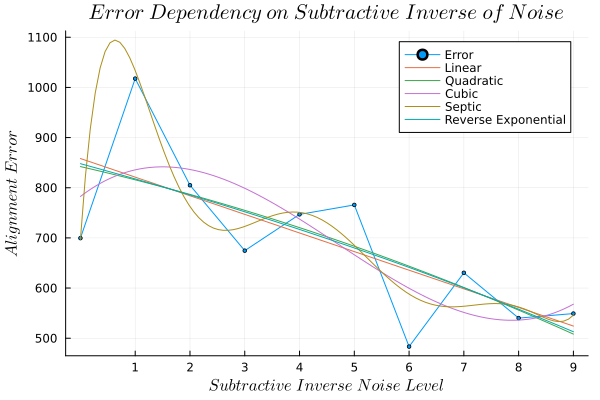

In [6]:
error_plot_rev = reverse(error_plot)
Plots.plot(j_list, error_plot_rev, markers=2, xticks=1:10, labels="Error")
Plots.plot!(Polynomials.fit(j_list, error_plot_rev, 1), extrema(j_list)..., labels="Linear")
Plots.plot!(Polynomials.fit(j_list, error_plot_rev, 2), extrema(j_list)..., labels="Quadratic")
Plots.plot!(Polynomials.fit(j_list, error_plot_rev, 3), extrema(j_list)..., labels="Cubic")
Plots.plot!(Polynomials.fit(j_list, error_plot_rev, 7), extrema(j_list)..., labels="Septic")
exp_fit = EasyFit.fitexp(j_list, error_plot_rev)
Plots.plot!(exp_fit.x, exp_fit.y, labels="Reverse Exponential")
title!(L"Error \ Dependency \ on \ Subtractive \ Inverse \ of \ Noise")
xaxis!(L"Subtractive \ Inverse \ Noise\ Level")
yaxis!(L"Alignment\ Error")

There is a positive trend, as expected. Linear, quadratic, and exponential are poor estimations.

Cubic and *septic* are better; however, we run the risk of overfitting these data.

Reversing the data yields no further improvement to the estimations.